# Result

Here are presented the first results of the analyse of Wikipedia RFA. For more detail about our work, method, timeline and objective, see the readme on the github reprository here: https://github.com/epfl-ada/ada-2024-project-supercoolteamname2024/tree/main

## Approbation rates vs outcome

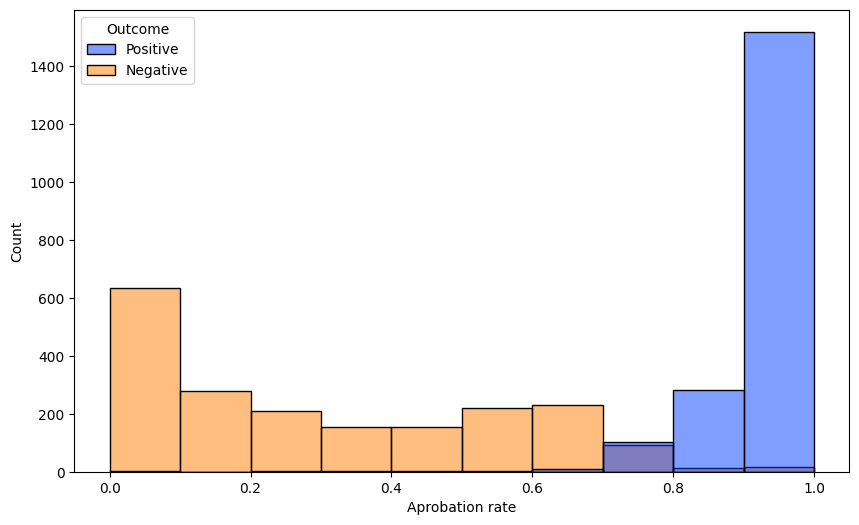

In [1]:
from src.scripts.GalPlots import *
plot_outcomes_approbation_rates("data/wiki-RfA.txt")

## Succes rate over years

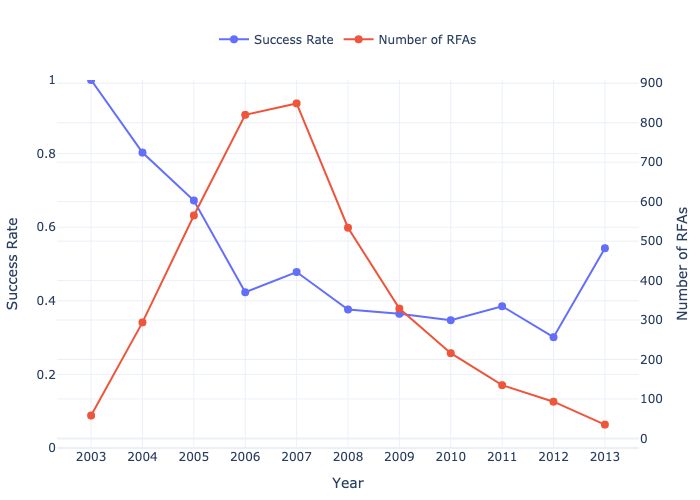

In [2]:
from src.scripts.GalPlots import *
plot_success_rates("data/wiki-RfA.txt")

# Categories distribution

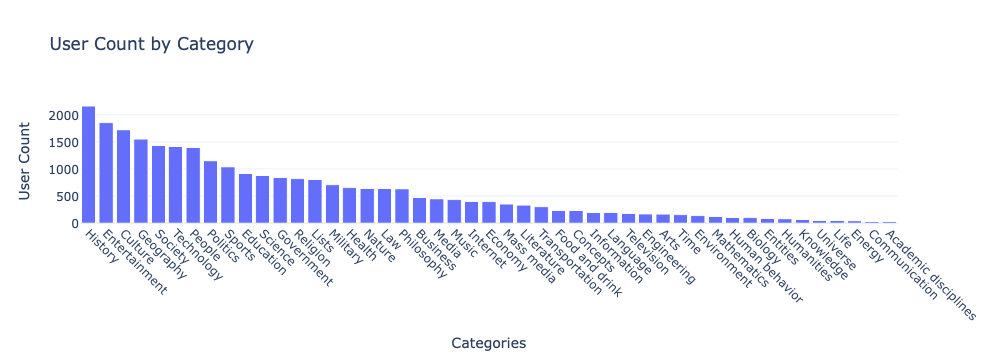

In [3]:
#Load
from src.scripts.EdPlots import *


The bar chart illustrates a diverse distribution of user interests across various categories, with each user potentially belonging to up to 4 different categories. The varying sizes of these categories may be attributed to the breadth of the topics themselves, as some categories, like Technology, may encompass broader subtopics such as Internet. Notably, certain categories have significantly higher user counts, while others are relatively small. To ensure statistical significance in subsequent analyses, we plan to exclude the smallest categories where the sample size may be insufficient for robust conclusions

# Participation rate same/different group

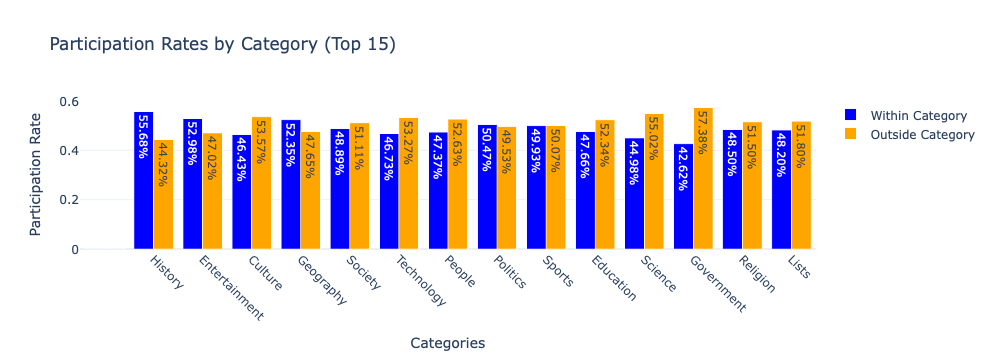

In [4]:
plot_participation_rates(df_vote, top_15_categories, title="Participation Rates by Category (Top 15)", top_n=15)

# Tolerance across same/different categories

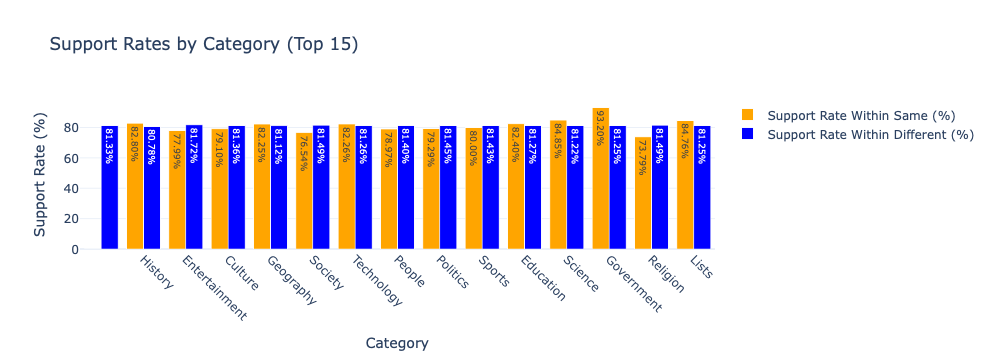

In [5]:
support_rates_df = plot_support_rates(df_vote, top_15_categories, title="Support Rates by Category (Top 15)",top_n=15)

Analyzing the top 10 largest categories, we observe that users are more inclined to participate in votes with a target related to topics that align with their own interests. This can be explained by the fact that individuals are likely to feel more knowledgeable or proficient in certain areas, making them more comfortable expressing their opinions or casting votes. This trend persists, even in the mid-sized categories ranked 10 to 20, suggesting a consistent preference for engaging with familiar topics across the user base.


# Does your subject of interest have an influence on your chance of admission??

## Table
 We tried to test the null hypothesis that tolerance rate is the same whether they are in the same/different category, p-values are on the last collumn.

Chi-Square Statistic: 313.34149202833083
P-Value: 3.867146592936798e-59
Chi-square test result: chi2 = 313.34, p-value = 0.0000
Statistically significant association between category and RfA success.


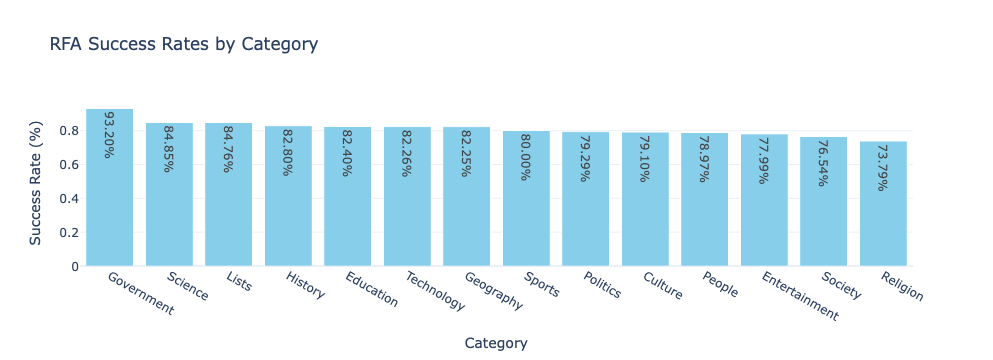

In [6]:
# Call the function with the success_data DataFrame
success_failure_df = analyze_success_failure(df_vote, title="Success and Failure Analysis by Category")
analyze_and_plot_success_rates(success_failure_df,title="RFA Success Rates by Category")

# Votants Behavior 

We are studying behavior of votants, trying to see if they became more or less strict over the years, for that we look at voters that have voted in more than 1 year.

Total voters analyzed for trends: 100
Trend
No Signif. Change    83
More Lenient         14
More Strict           3
Name: count, dtype: int64


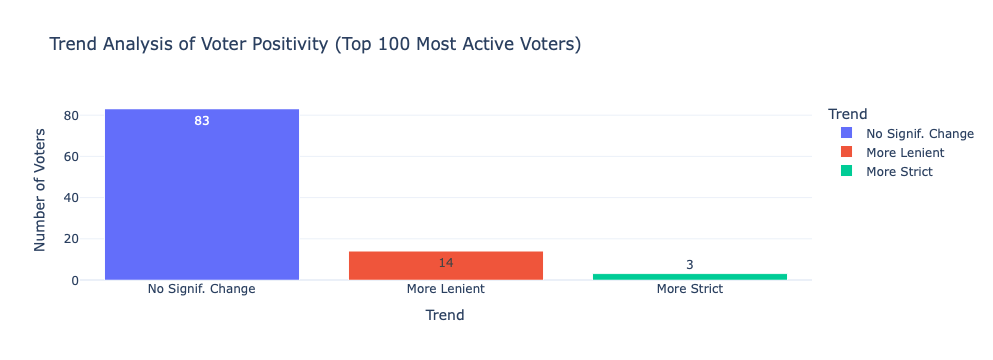

,Voter,Trend,Slope,p_value
0,Acalamari,No Signif. Change,-0.022540,0.256444
1,Airplaneman,More Lenient,0.067105,0.009061
2,Alison,No Signif. Change,0.051323,0.198567
3,America69,No Signif. Change,0.131132,0.091361
4,Antandrus,No Signif. Change,0.002976,0.554646


In [7]:
# Call the function with df_vote
trends_df = analyze_voter_trends(df_vote)

# Optionally, inspect the returned DataFrame
display(trends_df.head(5))


# Admin scores distribution

We first plot the distribution of adminscores over the data set.

## Admin score hist

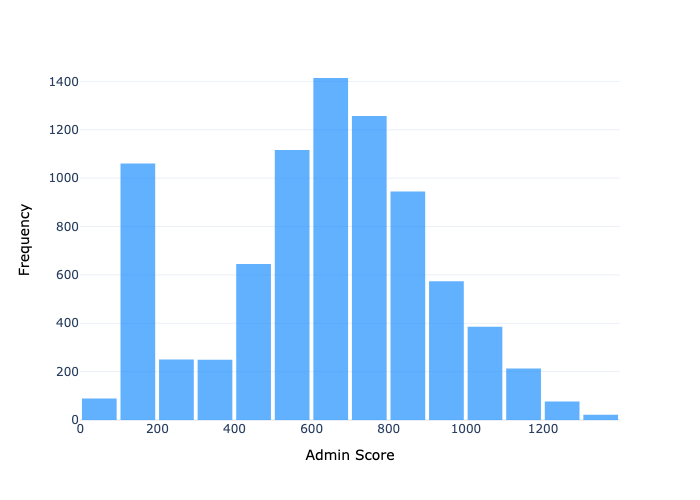

In [8]:
from src.scripts.GalPlots import *
plot_admin_scores_hist("data/scores.csv")

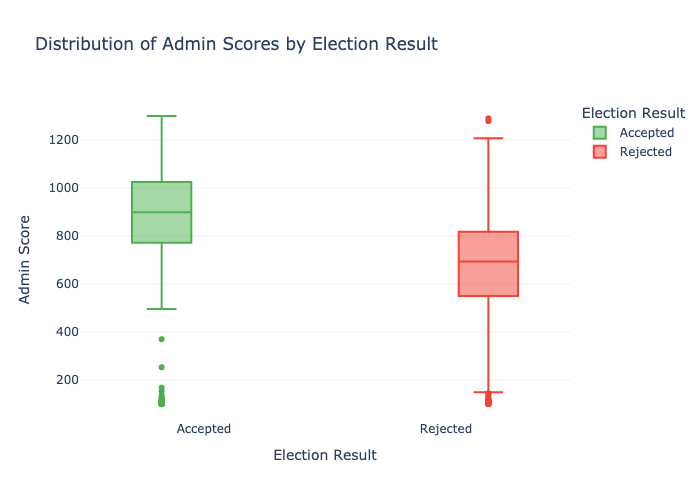

In [9]:
from src.scripts.TallulaPlots import *
Distribution_Admin_Scores('data/wiki-RfA.txt')

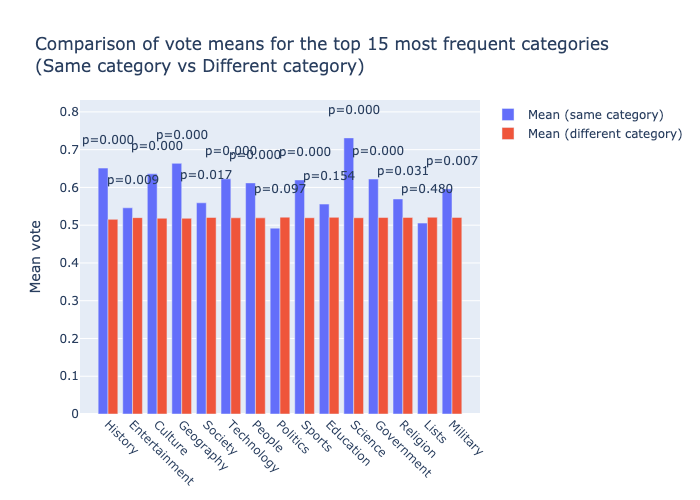

In [10]:
from src.scripts.TallulaPlots import *
Comparison_Vote_Category('data/wiki-RfA.txt')

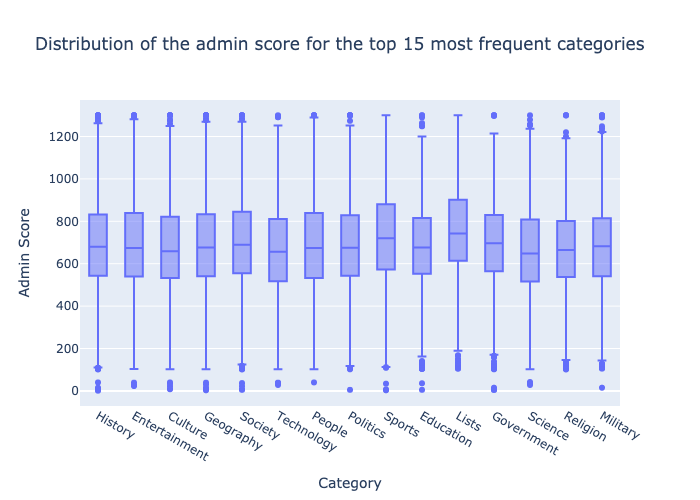

In [11]:
from src.scripts.TallulaPlots import *
Distribution_Admin_Score_Category('data/scores.csv')

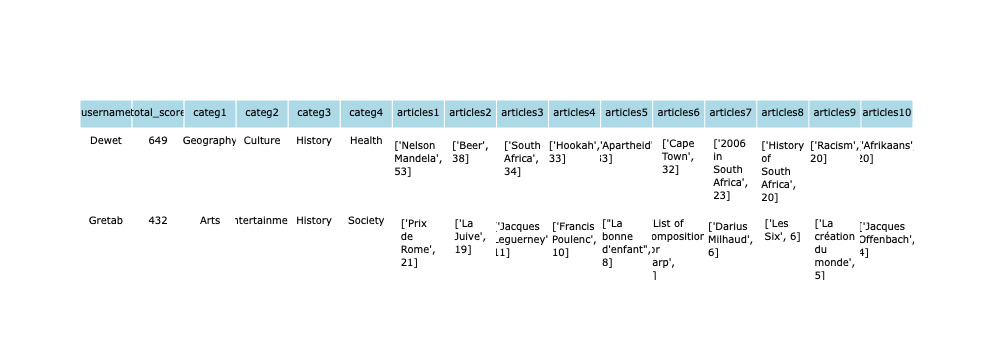

In [23]:
from src.scripts.TallulaPlots import *
tableau()

In [6]:
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
from matplotlib import cm
from community import community_louvain
from collections import Counter






interaction_matrix=pd.read_csv('data/voting_interaction_matrix.csv', index_col=0)
user_in_interaction_=pd.read_csv('data/voting_interaction_matrix.csv')
user_in_interaction=user_in_interaction_.index

# Create a graph from the interaction matrix
# We'll assume a weighted undirected graph where the weight is the voting interaction (1 or 0)
G = nx.Graph()

for user in interaction_matrix.index:
    for admin, vote in interaction_matrix.loc[user].items():
        if vote > 0:  
            G.add_edge(user, admin, weight=vote)

resolution=2
partition = community_louvain.best_partition(G, resolution=resolution)

nx.set_node_attributes(G, partition, "community")


# postProcessing the communities
# Remove communities with less than 5 users
community_sizes = Counter(partition.values()) 
num_communities = len(set(partition.values()))

min_size = 5
small_communities = {community for community, size in community_sizes.items() if size < min_size}
nodes_to_remove = [node for node, community in partition.items() if community in small_communities]
G_filtered = G.copy()
G_filtered.remove_nodes_from(nodes_to_remove)
updated_partition = {node: community for node, community in partition.items() if community not in small_communities}
community_sizes_updated = Counter(updated_partition.values()) 
print("Updated community sizes:", community_sizes_updated)
num_communities_updated = len(set(updated_partition.values()))
print(f"Number of communities detected: {num_communities_updated}")

# treat User Categories ---------------------------------------------------
feature_matrix=pd.read_csv('data/all_features_dataframe.csv')
feature_matrix = feature_matrix.drop_duplicates(subset='username', keep='first')

feature_matrix['community'] = feature_matrix['username'].map(updated_partition)
# Melt the category columns into a single column for easier aggregation
df_melted = feature_matrix.melt(
    id_vars=['username', 'community'],
    value_vars=['categ1', 'categ2', 'categ3', 'categ4'],
    var_name='category_level',
    value_name='category'
).dropna(subset=['category'])  # Drop rows where category is NaN

# Group by community and category to count occurrences
category_counts = df_melted.groupby(['community', 'category']).size().reset_index(name='count')

# Calculate the total number of users per community
community_sizes = feature_matrix.groupby('community').size().reset_index(name='total_users')

# Merge the counts with the total user count per community
category_counts = category_counts.merge(community_sizes, on='community')

# Calculate the percentage of each category within a community
category_counts['percentage'] = (category_counts['count'] / category_counts['total_users']) * 100

# Sort and display the results
category_counts = category_counts.sort_values(by=['community', 'percentage'], ascending=[True, False])
top_categories = category_counts.groupby('community').head(3)
 
community_top_categories = top_categories.groupby('community').apply(
    lambda group: "<br>".join(
        [f"{row['category']}: {row['percentage']:.2f}%" for _, row in group.iterrows()]
    )
).to_dict()

# The admin scores are in the second column of the feature_matrix
admin_scores = feature_matrix.iloc[:, 1]
feature_matrix['admin_score'] = admin_scores

# Group admin scores by community and calculate the mean score
mean_admin_scores = feature_matrix.groupby('community')['admin_score'].mean().to_dict()


# Interactive plot-------------------------------------------------------------------------------
community_sizes = {}
for node, community in updated_partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

community_graph = nx.Graph()

for community, size in community_sizes.items():
    community_graph.add_node(community, size=size)

for node1, node2 in G_filtered.edges:
    community1 = updated_partition[node1]
    community2 = updated_partition[node2]
    if community1 != community2:  
        if not community_graph.has_edge(community1, community2):
            community_graph.add_edge(community1, community2, weight=0)
        community_graph[community1][community2]['weight'] += 1

pos = nx.spring_layout(community_graph, k=20, iterations=100)

node_x = []
node_y = []
node_sizes = []
node_text = []
node_ids = []
for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_sizes.append(community_graph.nodes[node]['size'] * 10)
    # Get the top categories for this community
    top_category_info = community_top_categories.get(node, "No data available")
    mean_admin_score = mean_admin_scores.get(node, "No score available")
    node_text.append(
        f"Community {node}<br>"
        f"Users: {community_graph.nodes[node]['size']}<br>"
        f"Mean Admin Score: {mean_admin_score:.2f}<br>"
        f"{top_category_info}"
    )
    node_ids.append(node)
node_sizes = np.power(np.log10(node_sizes), 3) - 3

max_weight = max(data['weight'] for _, _, data in community_graph.edges(data=True))
min_weight = min(data['weight'] for _, _, data in community_graph.edges(data=True))

edges = {}
for community1, community2, data in community_graph.edges(data=True):
    x0, y0 = pos[community1]
    x1, y1 = pos[community2]
    weight = data['weight']
    normalized_thickness = 1 + (5 * (weight - min_weight) / (max_weight - min_weight))  # Scale between 1 and 6
    edges[(community1, community2)] = {
        "x": [x0, x1, None],
        "y": [y0, y1, None],
        "weight": weight,
        "thickness": normalized_thickness
    }


# Generate unique pastel colors for communities
unique_communities = set(updated_partition.values())  # Extract all community IDs
num_communities = len(unique_communities)

# Assign pastel colors to communities
community_colors = [to_hex(c) for c in cm.Pastel1(np.linspace(0, 1, num_communities))]

# Create a community-to-color map
community_color_map = {community: community_colors[i % len(community_colors)] 
                       for i, community in enumerate(unique_communities)}

# Map each user to the color of their community
user_color_map = {node: community_color_map[updated_partition[node]] 
                  for node in G_filtered.nodes}

node_color_map = {node: community_color_map[node] for node in node_ids}



# Updated graph setup
fig = go.Figure()

# Add node trace with unique pastel colors
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    marker=dict(
        size=node_sizes,
        color=[node_color_map[node] for node in node_ids],  # Use unique colors
        line=dict(width=2, color="black")
    ),
    hovertext=node_text,
    hoverinfo="text",
    customdata=node_ids,
    name="Communities"
))

# Add edge traces with opacity proportional to thickness and light gray color
max_thickness = max(edge_data["thickness"] for edge_data in edges.values())
min_thickness = min(edge_data["thickness"] for edge_data in edges.values())

for (community1, community2), edge_data in edges.items():
    normalized_thickness = (edge_data["thickness"] - min_thickness) / (max_thickness - min_thickness)
    # Map normalized thickness to opacity (e.g., between 0.2 and 1.0)
    edge_opacity = 0.2 + 0.8 * normalized_thickness
    
    fig.add_trace(go.Scatter(
        x=edge_data["x"],
        y=edge_data["y"],
        mode="lines",
        line=dict(width=edge_data["thickness"], color="#BABABA"),  # Light gray edges
        hoverinfo="none",
        name=f"Edge {community1}-{community2}",
        opacity=edge_opacity  # Set opacity based on thickness
    ))

# Layout settings with white background and no axes or labels
fig.update_layout(
    plot_bgcolor="white",  # Set background color to white
    paper_bgcolor="white",  # Set entire figure background color to white
    showlegend=False,  # Hide legend
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False  # Hide x-axis labels
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False  # Hide y-axis labels
    ),
    height=800,
    width=800,
    margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins
    title=dict(
        text="Community Graph",  # Replace with your desired title
        font=dict(size=20),  # Set font size
        x=0.5,  # Center the title horizontally
        y=0.95  # Adjust the vertical position
    )
)

# Display the figure
fig.show()

Updated community sizes: Counter({5: 1637, 7: 1332, 8: 1111, 9: 1106, 3: 1095, 4: 993, 1: 821, 2: 808, 6: 677, 15: 100, 11: 95, 10: 62, 13: 44, 12: 26, 0: 20, 22: 10, 16: 9, 14: 8, 30: 5})
Number of communities detected: 19


/var/folders/gm/941r48zd5qxcl4tb3v9q30440000gn/T/ipykernel_32513/2032807273.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_top_categories = top_categories.groupby('community').apply(


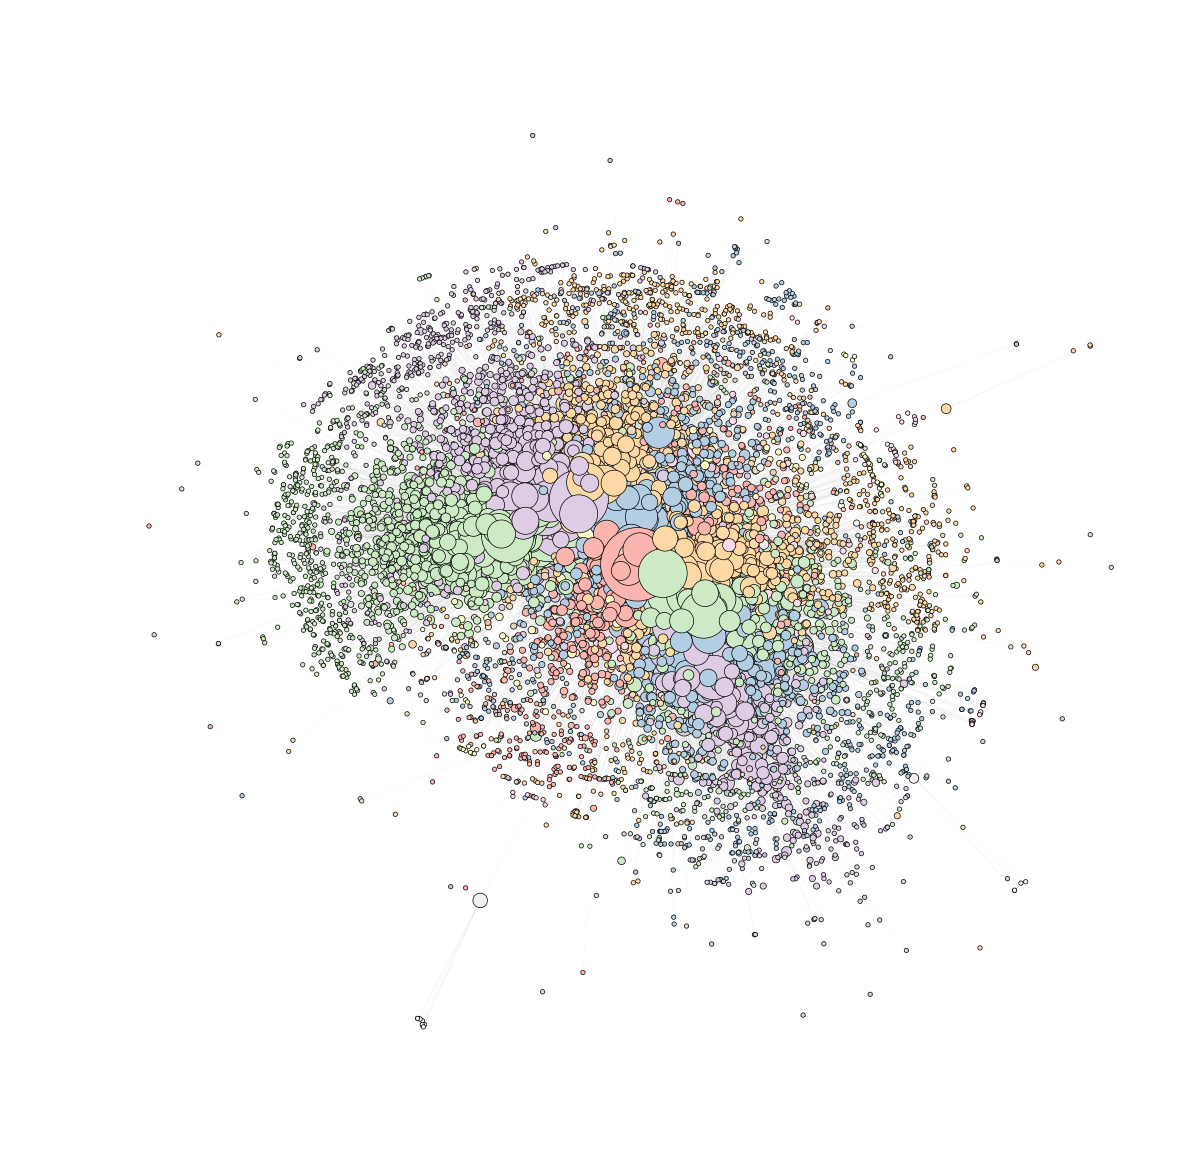

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import to_hex
import matplotlib.transforms as transforms

# Generate a unique pastel color for each node
node_colors = [user_color_map[node] for node in G_filtered.nodes]

# Calculate node sizes based on the number of votes (degree in the graph)
node_sizes = [G_filtered.degree(node) * 10 for node in G_filtered.nodes]

# Generate a single consistent layout
pos = nx.spring_layout(G_filtered, seed=42)

# Create the figure
fig, ax = plt.subplots(figsize=(15, 15))

# Apply a rotation transformation to the plot
rotate = transforms.Affine2D().rotate_deg(90)  # Rotate the graph by 90 degrees
ax.transData = rotate + ax.transData

# Draw edges with high transparency and very thin lines
nx.draw_networkx_edges(
    G_filtered,
    pos=pos,
    ax=ax,
    alpha=0.05,  # High transparency
    width=0.2    # Very thin lines
)

# Draw nodes with sizes and pastel colors
nx.draw_networkx_nodes(
    G_filtered,
    pos=pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    linewidths=0.5,  # Add a thin black outline to nodes
    edgecolors="black"
)

# Remove axes for better aesthetics
plt.axis("off")
plt.show()
